#**IndeLLM**
Welcome to IndeLLM, an easy and free-to-use indel pathogenicity predictor based on Protein Language Models.

IndeLLM also provides a per-position protein fitness damage score to aid in interpreting the provided predictions. For more information about input files, runtimes and common issues, scroll down to the Appendix section, visit our GitHub: https://github.com/OriolGraCar/IndeLLM.git, or read the accompanying paper [Article](https://doi.org/10.1016/j.patter.2025.101425).

To get started, run the cells in this notebook sequentially using the information provided in each section.

<img src="https://raw.githubusercontent.com/OriolGraCar/IndeLLM/main/img/graphicalabstract.png" width="500">



## Setup

Start by running the cell below to set up IndeLLM and all required dependencies.

In section "2. IndeLLM parameters", one can choose from different options to use:

*   **PLM Score**: This option controls whether or not the zero-shot scoring function should be used. This scoring function can be used to predict indel effects on any organism and is necessary if one wants to have the per position interpretation.
*   **PLM Selection**: Select which protein language model to use for the PLM scoring. The recommended model is ESM2 650M.
*   **Siamese Prediction**: This option controls whether or not the Siamese model should be used. Predictions using this model are more accurate than with the PLM score but are only designed for human sequences.




In [ ]:
#@title 1. Download IndeLLM

#@markdown Download IndeLLM and install dependencies in the cloud.
#install viewer here

from IPython.utils import io
import os
captured = ""
GIT_REPO = 'https://github.com/OriolGraCar/IndeLLM.git'
try:
  with io.capture_output() as captured:
    %shell rm -rf indellm
    !git clone --branch main {GIT_REPO} indellm

    # Install the required versions of all dependencies.
    %shell pip3 install -r ./indellm/requirements.txt
    %shell pip3 install py3Dmol

    # Make necessary folders or donwload anything else
    #%shell mkdir -p /content/folder
except:
  print(captured)
  raise

# add package to the path
import sys
sys.path.append('/content/indellm')

print("Install succesful")

# Import important modules
print("Importing Modules...")
from indellm import utils, scorer, model
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


Install succesful
Importing Modules...


In [ ]:
#@title 2. IndeLLM parameters

#@markdown  Select parameters for the predictions.
#@markdown
#@markdown
#@markdown  Check PLM_score to run the IndeLLM scoring on the desired sequences.

# create needed directory
!mkdir Results
# Create checkboxes for the options
PLM_score = True #@param {type:"boolean"}

#@markdown  Chose Protein Language Model (PLM) to use for the IndeLLM scoring.

# Create a dropdown menu for PLMS
Select_PLM = "ESM2 650M"  #@param ['ESM2 650M', 'ESM1b', 'ESM2 150M', 'ESM1v', 'ESM2 3B', 'ESM2 15B', 'ESM2 35M', "ProtBert"]

#@markdown  Check Siamese_Prediction to run the siamese model on your data.

Siamese_Prediction = True  #@param {type:"boolean"}

print(f"Selected parameters:\n   PLM scoring: {PLM_score}.\n   PLM to use: {Select_PLM}.\n   Run siamese prediction {Siamese_Prediction}.")
if not Siamese_Prediction and not PLM_score:
  raise Exception("No prediction method selected. Please select at least one from PLM_score and Siamese_Prediction")

mkdir: cannot create directory ‘Results’: File exists
Selected parameters:
   PLM scoring: True.
   PLM to use: ESM2 650M.
   Run siamese prediction True.


\## Prepare Indel sequences

To prepare the indel sequences, input the wildtype and mutant sequences in the next block "3. Running sequences independently".

To process sequences in batches, upload a csv with the columns id,wt_seq,mut_seq to the notebook and run the section "4. Process batch file".

Example csv data:

*id,wt_seq,mut_seq*

*1,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG*


In [ ]:
#@title 3. Option 1: Run sequences independently

#@markdown Enter the amino acid sequences to compare.
#@markdown
#@markdown After selecting the sequences press run.

wildtype_sequence = 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG'  #@param {type:"string"}
mutant_sequence = 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG'  #@param {type:"string"}

# Prepare data
# Create a Dataframe with the expected column names
data_df = pd.DataFrame({"id":["1"],
                    "mut_seq":[mutant_sequence],
                    "wt_seq":[wildtype_sequence]})


# If the scoring is selected run the scoring for the sequences

if PLM_score:
  # Initialize Scorer
  print("Initializing Scorer...")
  plm_scorer = scorer.Scorer()

  # Pick PLLM to use
  print(f"Initializing PLM {Select_PLM}...")
  # Map dropdown name to expected names:
  name_map = {"ESM2 35M": "ESM2_35M",
              "ESM2 150M": "ESM2_150M",
              "ESM2 650M": "ESM2_650M",
              "ESM2 3B": "ESM2_3B",
              "ESM2 15B": "ESM2_15B",
              "ESM1b": "ESM1b",
              "ESM1v": "ESM1v",
              "ProtBert":"BertRost"}

  plm_scorer.initialize_plm(name_map[Select_PLM])

  # Asign the df to the scorer (For now this is a bit wacky, to be updated)
  plm_scorer.df = data_df
  plm_scorer.results_path = "Results"
  print("Scoring sequences")
  wt_positional, mut_positional, df_final = plm_scorer.score_data(masked=False, disable_tqm=False)
  print("Scoring Finished")

if Siamese_Prediction:
  print("Initializing IndeLLm siamese model")
  m = model.Indellm()

  print("Running Model")
  m.run(
        data_location = data_df,
        model_location = "indellm/models/weights.pth",
        plm_name = "ESM2_650M", # Provided checkpoint is trained for ESM2 650M only
        embedding_path = "embeddings",
        output_path = "Results",
        output_name = "Predictions",
        threshold = 0.46
        # 0.46 is the optimal threshold found on general data, can be updated as needed
        )

  print("IndeLLM Siamese Predictions Finished")




Initializing Scorer...
Initializing PLM ESM2 650M...
Scoring sequences


Processing sequences: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Scoring Finished
Initializing IndeLLm siamese model
No GPU or MPS available, using the CPU instead.
Running Model
Generating embedings
There are 1 GPU(s) available.
Device name: Tesla T4
Loading model: esm2_t33_650M_UR50D...


100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


Your prediction results are saved in Results/Predictions.txt
IndeLLM Siamese Predictions Finished


In [ ]:
#@title 4. Option 2: Process batch file

#@markdown Select the csv file to process.
#@markdown
#@markdown The csv file needs to contain a header with three columns, id, wt_seq and mut_seq
#@markdown
#@markdown In order for the file to be found it should be uploaded to the notebook first.
#@markdown
#@markdown Always save the files used for future reference (Colab storage is temporal).

import os

csv_file = ''  #@param {type:"string"}

if PLM_score:
  # Initialize Scorer
  print("Initializing Scorer...")
  plm_scorer = scorer.Scorer()

  # Pick PLLM to use
  print(f"Initializing PLM {Select_PLM}...")
  # Map dropdown name to expected names:
  name_map = {"ESM2 35M": "ESM2_35M",
              "ESM2 150M": "ESM2_150M",
              "ESM2 650M": "ESM2_650M",
              "ESM2 3B": "ESM2_3B",
              "ESM2 15B": "ESM2_15B",
              "ESM1b": "ESM1b",
              "ESM1v": "ESM1v",
              "ProtBert":"BertRost"}

  plm_scorer.initialize_plm(name_map[Select_PLM])

  # load csv
  plm_scorer.load_csv_to_score(csv_file, "Results")
  data_df = plm_scorer.df

  print("Scoring sequences")
  wt_positional, mut_positional, df_final = plm_scorer.score_data(masked=False, disable_tqm=False)
  print("Scoring Finished")

if Siamese_Prediction:
  print("Initializing IndeLLm siamese model")
  m = model.Indellm()

  print("Running Model")
  m.run(
        data_location = csv_file,
        model_location = "indellm/models/weights.pth",
        plm_name = "ESM2_650M", # Provided checkpoint is trained for ESM2 650M only
        embedding_path = "embeddings",
        output_path = "Results",
        output_name = "Predictions",
        threshold = 0.46
        # 0.46 is the optimal threshold found on general data, can be updated as needed
        )
  data_df = m.data_df

  print("IndeLLM Siamese Predictions Finished")





## Results

To visualize the results run the following two cells:

"5. Show Prediction" will create a table with the predictions for all the selected sequences.

"6. Sequence representation" will show the alignments and the per-position assessment of fitness effects. In section 6, one can provide a pdb to map the per-position predictions to the B-factors and a CSV with annotations to add to the plot. For both the pdb representation and annotations it is necessary that the option "PLM_score" was selected in the setup section.

All the results can be downloaded in the downloads section together with a README of the contents of each file.

In [ ]:
#@title 5. Show IndeLLM Predictions.

#@markdown The provided predictions use the optimal thresholds found in the dataset used to develop these methods.
#@markdown
#@markdown  For better results, adjusting these thresholds with calibration data is recommended since different families and organisms may have different optimal thresholds.
df_data_holder = {}

if PLM_score: # This means we have a PLM score file
    name_map = {"ESM2 35M": "ESM2_35M",
                "ESM2 150M": "ESM2_150M",
                "ESM2 650M": "ESM2_650M",
                "ESM2 3B": "ESM2_3B",
                "ESM2 15B": "ESM2_15B",
                "ESM1b": "ESM1b",
                "ESM1v": "ESM1v",
                "ProtBert":"BertRost"}

    plm_df = pd.read_csv(f"Results/scores_{name_map[Select_PLM]}.csv")
    df_data_holder.setdefault("id",plm_df["id"].to_list())

    # Compute IndeLLM score
    result_list = (plm_df['IndeLLM_mut'] - plm_df['IndeLLM_wt']).tolist()
    df_data_holder.setdefault("IndeLLM_Score", result_list)

    # Compute indel length and type
    indel_length = abs(plm_df["indel_length"]).to_list()
    indel_type = ["Deletion" if value < 0 else "Insertion" for value in plm_df["indel_length"]]
    df_data_holder.setdefault("Indel_length", indel_length)
    df_data_holder.setdefault("Indel_type", indel_type)

    # Assign labels based on predefined threshold
    threshold_map = {"ESM2 35M": 0.2,
                     "ESM2 150M": 0.2,
                     "ESM2 650M": 0.2,
                     "ESM2 3B": 0.2,
                     "ESM2 15B": 0.2,
                     "ESM1b": 0.2,
                     "ESM1v": 0.2,
                     "ProtBert":0.2}
    prediction_label = ["Pathogenic" if value < threshold_map[Select_PLM] else "Benign" for value in result_list]
    df_data_holder.setdefault("IndeLLM_Score_Prediction", prediction_label)

if Siamese_Prediction: # This means we have a Siamese score file
    siamese_df = pd.read_csv("Results/Predictions.txt")

    df_data_holder.setdefault("id", siamese_df["id"].to_list())
    df_data_holder.setdefault("IndeLLM-Siamese_Score", siamese_df["score"].to_list())

    # create easy labels
    prediction_label = ["Pathogenic" if value == 1 else "Benign" for value in siamese_df["prediction"]]
    df_data_holder.setdefault("IndeLLM_Siamese_Prediction", prediction_label)

final_df = pd.DataFrame(df_data_holder)
final_df.to_csv("Results/cleaned_prediction.csv", index=False)

display(final_df)




,id,IndeLLM_Score,Indel_length,Indel_type,IndeLLM_Score_Prediction,IndeLLM-Siamese_Score,IndeLLM_Siamese_Prediction
0,1,-2.153913,3,Deletion,Pathogenic,0.936868,Pathogenic


<class 'str'>
0    1
Name: id, dtype: object
target            0 MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYN
                  0 ||||||||||||||||||||||||||||||||||||||---|||||||||||||||||||
query             0 MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPP---RLIFAGKQLEDGRTLSDYN

target           60 IQKESTLHLVLRLRGG 76
                 60 |||||||||||||||| 76
query            57 IQKESTLHLVLRLRGG 73



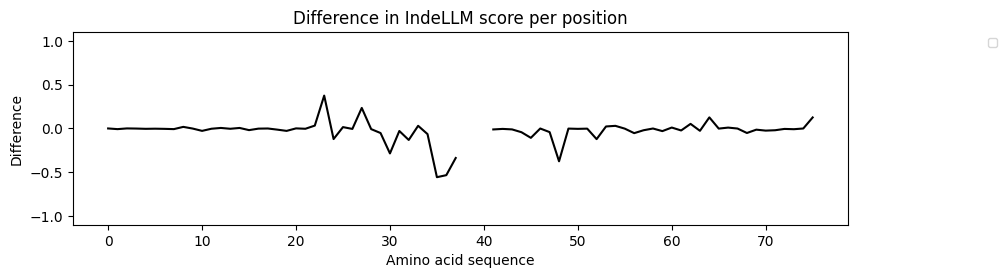

In [ ]:
#@title 6. Results Visualization.

#@markdown Add the selected id for the sequence to plot. If no batch processing was used the id is 1.
#@markdown
#@markdown Provide the name of the csv and pdb files for the representations. These files needs to be uploaded to the colab notebook before running the cell.
#@markdown
#@markdown If no pdb or annotations are needed, leave those fields empty.
#@markdown
#@markdown The annotations file should contain the columns name,start,stop. With name being the name of the domain and start and stop the positional indexes for that domain.

from Bio.Align import PairwiseAligner
from Bio.pairwise2 import format_alignment
from Bio import PDB
import py3Dmol
import matplotlib.pyplot as plt
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

id_to_plot = "1" #@param {type:"string"}
pdb = "" #@param {type:"string"}
annotations = "" #@param {type:"string"}

# Function definitions
def calculate_difference(wtscores, mutscores, wt_seq, mut_seq):
    aligner = PairwiseAligner(score="blastp")
    aligner.mode = 'global'
    aligner.open_gap_score = -12
    aligner.extend_gap_score = 0
    alignment = aligner.align(wt_seq, mut_seq)[0]
    aligned_wt = alignment[0]
    aligned_mut = alignment[1]
    difference_score = []

    wt_idx, mut_idx = 0, 0

    for wt_char, mut_char in zip(aligned_wt, aligned_mut):
        if wt_char == '-':
            difference_score.append(None)
            mut_idx += 1 #skips to next score in non-gapped sequence
        elif mut_char == '-':
            difference_score.append(None)
            wt_idx += 1 #skips to next score in non-gapped sequence
        else:
            difference_score.append(mutscores[mut_idx] - wtscores[wt_idx])
            wt_idx += 1
            mut_idx += 1

    return difference_score

def plot_difference(diff, annotations, id_to_plot, start_loss):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'grey', 'cyan', 'yellow']

    plt.figure(figsize=(10, 2.5))
    plt.plot(diff, color = 'black')

    names_to_color = {}
    legend_labels = []

    if annotations:
      annotations = pd.read_csv(annotations)
      annotations['start'] = pd.to_numeric(annotations['start'])
      annotations['stop'] = pd.to_numeric(annotations['stop'])
      for i, row in annotations.iterrows():
          start = row['start']
          stop = row['stop']
          if start_loss > 0:
            start = start - start_loss
            stop = stop - start_loss

          if start < 0 and stop < 0 or start > len(diff) and stop > len(diff):
            continue #Neither stop or start are within bounds
          elif start < 0:
            start = 0  #start is out of bounds, set to 0
          elif stop > len(diff):
            stop = len(diff) #stop is out of bounds, set to max length of plot

          name = row['name']
          if name not in names_to_color:
              color = colors[i % len(colors)]
              names_to_color[name] = color
          else:
              color = names_to_color[name]
          if name not in legend_labels:
              plt.axvspan(start, stop, ymin=-1.1, ymax=1.1, color = color, alpha = 0.1, label = name)
              legend_labels.append(name)
          else:
              plt.axvspan(start, stop, ymin=-1.1, ymax=1.1, color = color, alpha = 0.1)
    plt.title('Difference in IndeLLM score per position')
    plt.xlabel('Amino acid sequence')
    plt.ylabel('Difference')
    plt.legend(fontsize = 'small', loc = 'upper right', bbox_to_anchor=(1.2, 1))
    plt.ylim(-1.1, 1.1)
    plt.savefig(f"Results/{id_to_plot}_representation.png")

    return plt.show()

def align_to_pdb_and_slice_diff(pdbfile, wt_seq, diff):
    structure = PDB.PDBParser(QUIET=True).get_structure('protein', pdbfile)
    ppb = PDB.PPBuilder()
    pdb_seq = ''
    for pp in ppb.build_peptides(structure):
        pdb_seq += (pp.get_sequence())

    aligner = PairwiseAligner(score="blastp")
    aligner.mode = 'global'
    aligner.open_gap_score = -12
    aligner.extend_gap_score = 0
    alignment = aligner.align(wt_seq, pdb_seq)[0]
    aligned_wt = alignment.aligned[0]
    aligned_pdb = alignment.aligned[1]

    if len(aligned_pdb) >= 2 or len(aligned_wt) >= 2: #Gap in the alingment
        raise Exception("PDB does not match wildtype sequence")

    diff_updated = diff

    if aligned_pdb[0][0] == 0 and aligned_wt[0][0] == 0:
        return diff_updated, aligned_pdb, aligned_wt

    if aligned_wt[0][0] != 0: #PDB sequence is shorter than wt_seq, slice diff by start and end of pdb sequence
        diff_updated = diff_updated[aligned_pdb[0][0]:aligned_pdb[0][1]]

    if aligned_pdb[0][0] != 0: #PDB sequence is longer than wt_seq, add zeros at start and end of diff to macth PDB lenght
        zeros_at_start = np.zeros(aligned_pdb[0][0], dtype=np.float64)
        zeros_at_end = np.zeros(len(pdb_seq) - aligned_pdb[0][1], dtype=np.float64)
        diff_updated = np.concatenate([zeros_at_start, diff_updated, zeros_at_end])

    return diff_updated, aligned_pdb, aligned_wt

def color_pdb(diff_updated, pdbfile):
    structure = PDB.PDBParser(QUIET=True).get_structure('protein', pdbfile)
    model = structure[0]

    nan_indices = []
    for i, score in enumerate(diff_updated):
        if score is None:
            diff_updated[i] = 100 # Removes Na for only for the deletion or inserted residues
            nan_indices.append(i)

    for atom in model.get_atoms():
         atom.set_bfactor(0.0) # setting all bfactors to 0.0

    for res, residue in enumerate(model.get_residues()):
      try:
        bfactor = diff_updated[res]
        for atom in residue.get_atoms():
            atom.set_bfactor(bfactor)
      except:
        continue

    io = PDB.PDBIO()
    io.set_structure(structure)
    # extract file name
    pdbname = pdbfile.split("/")[-1].split(".")[0]
    io.save(f'Results/{pdbname}_updated.pdb')

    with open(f'Results/{pdbname}_updated.pdb', 'r') as f:
        lines = f.readlines()

    def get_colors(bfactor):
      if bfactor < -0.02:
        return 'red'
      elif -0.02 <= bfactor <= 0.02:
        return 'white'
      elif 0.02 < bfactor < 1:
        return 'blue'
      else:
        return 'green'

    view = py3Dmol.view(width=800, height=600)
    view.addModel(''.join(lines), 'pdb')

    for line in lines:
      if line.startswith("ATOM") or line.startswith("HETATM"):
        try:
            serial = int(line[6:11].strip())  # Atom serial number
            bfactor = float(line[60:66].strip())  # Extract B-factor
            color = get_colors(bfactor)  # Assign color
            view.setStyle({"serial": serial}, {"cartoon": {"color": color}})

        except ValueError:
            continue  # Skip invalid lines
      view.setBackgroundColor("white")
      view.zoomTo()
        #print("Residues in indel:", nan_indices)

    return view.show()

#--------------------------- CODE -------------------------------------

# fetch the sequences and plot the aligment.
#data_df["id"] = data_df["id"].astype(str)
wtseq = data_df[data_df["id"] == id_to_plot]["wt_seq"].to_list()[0]
mutseq = data_df[data_df["id"] == id_to_plot]["mut_seq"].to_list()[0]

# set up aligner
aligner = PairwiseAligner(score="blastp")
aligner.mode = 'global'
aligner.open_gap_score = -12
aligner.extend_gap_score = 0

# sliced tracker
start_loss = 0

# Truncate if  necessary.
if (len(wtseq) > 1022 or len(mutseq) > 1022):
  #start, end, length_diff, indel_type = utils.get_indel_info(wtseq, mutseq)
  wtseq_uncut = wtseq
  wtseq, mutseq = utils.truncate_sequences(wtseq, mutseq)
  print("Aligment of the truncated sequence used")
  alignment = aligner.align(wtseq_uncut, wtseq)[0]
  start_loss = alignment.coordinates[0][1]

# Create aligment
alignment = aligner.align(wtseq, mutseq)[0]

# Print the alignment with adjusted displayed indexes
print(alignment.format())

if PLM_score: # This means we have a PLM score file
    name_map = {"ESM2 35M": "ESM2_35M",
                "ESM2 150M": "ESM2_150M",
                "ESM2 650M": "ESM2_650M",
                "ESM2 3B": "ESM2_3B",
                "ESM2 15B": "ESM2_15B",
                "ESM1b": "ESM1b",
                "ESM1v": "ESM1v",
                "ProtBert":"BertRost"}

    # extract per positions scores
    wtscores = pd.read_csv(f'Results/wt_fitnesses_{name_map[Select_PLM]}.csv')
    mutscores = pd.read_csv(f'Results/mut_fitnesses_{name_map[Select_PLM]}.csv')
    try:
      id_to_plot_c = int(id_to_plot)
    except:
      id_to_plot_c = id_to_plot
    id_wtscores = wtscores.loc[wtscores['id'] == id_to_plot_c]
    id_wtscores = id_wtscores.iloc[0, 1:].tolist()
    id_mutscores = mutscores.loc[mutscores['id'] == id_to_plot_c]
    id_mutscores = id_mutscores.iloc[0, 1:].tolist()

    # calculate differences and plot
    difference_score = calculate_difference(id_wtscores, id_mutscores,
                                            wtseq, mutseq)
    diff_plot = plot_difference(difference_score, annotations, id_to_plot, start_loss)

    # create pdb plot
    if pdb:
      diff_updated, aligned_pdb, aligned_wt = align_to_pdb_and_slice_diff(pdb, wtseq, difference_score)
      color_pdb(diff_updated, pdb)

## Downloads

Pressing the run button should download a zip with all the raw and processed files. If the download does not trigger, please check your adblock settings.

All files that will be downloaded can be found in the Results folder.

The downloaded files are the following:


*   **cleaned_prediction.csv**: csv with all the scores requested, indel information and pathogenicity labels based on the default thresholds.
*   **scores_PLMname.csv**: Raw scoring file for the IndeLLM score.
*   **wt_fitnesses_PLMname.csv**: Per positions likelihood scores for each of the amino acids in the wildtype sequence.
*   **mut_fitnesses_PLMname.csv**: Per positions likelihood scores for each of the amino acids in the mutant sequence.
*   **Predictions.txt**: Prediction results for the IndeLLM siamese model.

Additionaly, a pdb file with the per position variant impact in the B-factors column and a plot of the per position impacts can also be found there if sequence representation was run for that variant.


In [ ]:
import shutil
from google.colab import files
import os
#@title 7. Download Results.

# Define the output zip file
output_filename = '/content/IndeLLM_results.zip'

# Compress the folder into a zip file
shutil.make_archive("IndeLLM_results", 'zip',"/content/Results")

# Provide a download link for the zip file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Appendix

### **Uploading files**

For uploading files, drag them to the file section on the Google Colab, see image. Please note that the files will only be stored temporarily while the session is running.

<p align="center">
  <img src="https://raw.githubusercontent.com/OriolGraCar/IndeLLM/main/img/upload.png" width="300">
</p>

### **File formats**

The bash submission file should be a csv with the columns, id, wt_seq and mut_seq

Example csv data:

*id,wt_seq,mut_seq*

*1,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG*

The uploaded pdb should match the wildtype sequence or part of the wildtype sequence but contain no amino acid differences or unresolved regions. AlphaFold pdbs are accepted.

For the annotations, it is necessary to provide a csv with the following columns:

*name,start,stop*

*Ig-like,25,119*

Please note that for sequences longer than 1022 amino acids, the sequences will be truncated (cropped) first, shifting the annotations. Please double check the produced alignment to ensure that they were processed accordingly.

For the PDB representation, be aware that the render may hang up if the uploaded sequence is too long (~1000 aa).

### **Sequence processing**

Long sequences will be cropped centred at the indel. One can observe the resulting cropped sequences from the visualization section.

If the automatic cropping is not desired please provide already cropped sequences as input.

Alternatively, one can get the cropped sequences by running the following code:

```python
from indellm import utils

wtseq_cropped, mutseq_cropped = utils.truncate_sequences(wtseq, mutseq)
```

### **Inputs and runtimes**

Loading the models is the most computationally intensive part. Once the models are loaded each sequence can be processed within a few seconds (10-20s) each.

### **Bugs and issues**

Please use IndellM's GitHub to communicate any experienced bugs or issues with the code.

### **License**

The source code of IndeLLM is licensed under MIT.



